In [7]:
%matplotlib inline
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
train_path = r'C:\Users\frenc\Documents\dottorato\ising\train'
valid_path = r'C:\Users\frenc\Documents\dottorato\ising\validation'

In [1]:
import os
import numpy as np
from tqdm import tqdm
from random import shuffle
def one_hot_label(img):
    # img is the file name of a configuration
    label, T, _, = img.split('_')
    if label == 'low':
        ohl = np.array([1, 0])
    elif label == 'high':
        ohl = np.array([0, 1])
    return ohl, T

def data_with_label(data_path, *args):
    data = []
    if args: 
        for category in args:
            category_path = os.path.join(data_path, category)  # Category folder
            for i in tqdm(os.listdir(category_path)):
                path = os.path.join(category_path, i) 
                img = np.load(path)  # Assuming the files are NumPy arrays
                data.append([img.astype(dtype='float32'), one_hot_label(i)])
        shuffle(data)
    return data

train_path = r'C:\Users\frenc\Documents\dottorato\ising\train'
valid_path = r'C:\Users\frenc\Documents\dottorato\ising\validation'


train_set = data_with_label(train_path, 'low', 'high')

valid_set = data_with_label(valid_path, 'low', 'high')

100%|██████████| 1600/1600 [00:01<00:00, 914.13it/s] 


In [2]:
tr_img_data = np.array([i[0] for i in train_set])
tr_lbl_data = np.array([i[1][0] for i in train_set])
tr_Temp_data = np.array([i[1][1] for i in train_set])
val_img_data = np.array([i[0] for i in valid_set])
val_lbl_data = np.array([i[1][0] for i in valid_set])
val_Temp_data = np.array([float(i[1][1]) for i in valid_set])



In [5]:
L = val_img_data.shape[2]

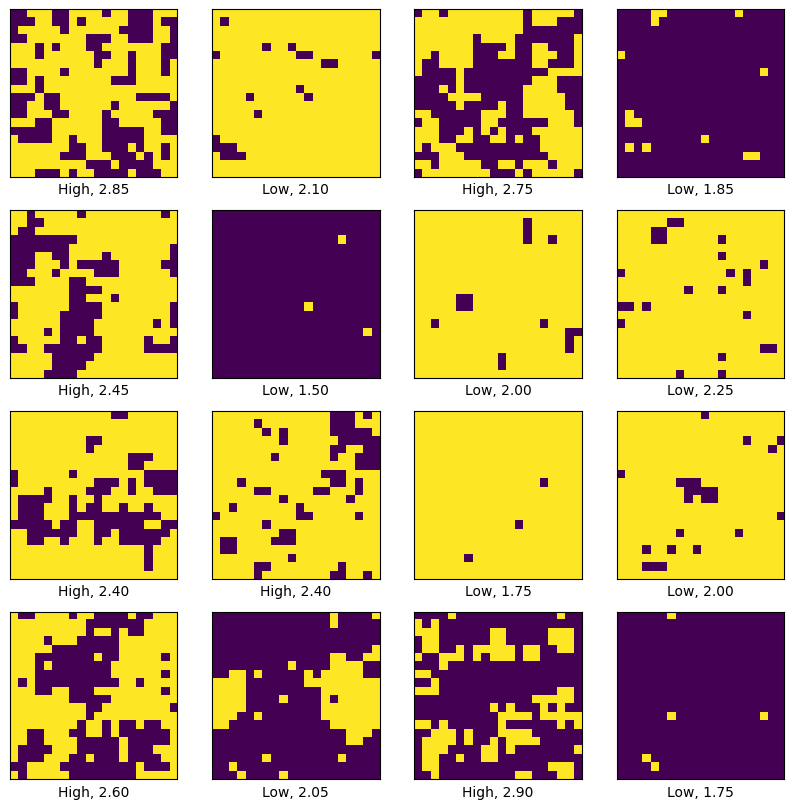

In [8]:
plt.figure(figsize=(10,10))
for i in range(16):
    #idx=bad_predictions[i]
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tr_img_data[i])
    if tr_lbl_data[i][0] == 1:
        label = "Low"
    elif tr_lbl_data[i][1] == 1:
        label = "High"
    plt.xlabel(f'{label}, {tr_Temp_data[i]}')

In [9]:

# Assuming `tr_img_data` and `tr_lbl_data` are already loaded numpy arrays
train_images = torch.tensor(tr_img_data, dtype=torch.float32)  # Input data (e.g., (N, 20, 20))
train_labels = torch.tensor(tr_lbl_data, dtype=torch.float32)  # Labels (e.g., (N,))
val_images = torch.tensor(val_img_data, dtype=torch.float32)  # Input data (e.g., (N, 20, 20))
val_labels = torch.tensor(val_lbl_data, dtype=torch.float32)  

In [10]:
def calculate_accuracy(predictions, true_labels):
    # Convert predictions and true_labels into numpy arrays if they aren't already
    
    predictions = predictions.detach().cpu().numpy()  # Move to CPU and detach from the graph
    true_labels = true_labels.detach().cpu().numpy() 


    # Calculate the number of correct predictions
    correct_predictions = np.sum(np.argmax(predictions, axis=1) == np.argmax(true_labels, axis=1))
    total_predictions = len(predictions)

    # Return accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

In [11]:
def train_model(model, train_images, train_labels, val_images, val_labels, epochs=15, batch_size=32, lr=0.001):
    """
    Train a model using the provided training data.

    Parameters:
        model: The model to train (instance of nn.Module).
        train_images: Tensor of input data (e.g., shape (N, 20, 20)).
        train_labels: Tensor of labels (e.g., shape (N,)).
        val_images: Tensor of validation images.
        val_labels: Tensor of validation labels.
        epochs: Number of training epochs.
        batch_size: Batch size for training.
        lr: Learning rate.
    """
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert to the correct device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_images, train_labels = train_images.to(device), train_labels.to(device)
    val_images, val_labels = val_images.to(device), val_labels.to(device)
    
    # Training loop
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0 
        accuracy_epoch = []
        
        # Shuffle data and iterate in mini-batches
        perm = torch.randperm(train_images.size(0))
        for i in range(0, len(train_images), batch_size):
            indices = perm[i:i+batch_size]
            batch_images, batch_labels = train_images[indices], train_labels[indices]

            # Forward pass: Compute predicted y by passing x to the model
            outputs = model(batch_images)
            
            accuracy = calculate_accuracy(outputs, batch_labels)
            # Calculate the loss
            loss = criterion(outputs, batch_labels)

            epoch_loss += loss.item()
            # Zero gradients, backward pass, optimizer step
            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update the model parameters
            accuracy_epoch.append(accuracy)
        
        # Calculate average loss and accuracy for the epoch
        epoch_loss = epoch_loss / (len(train_images) // batch_size)
        accuracy_epoch = np.mean(accuracy_epoch)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # No need to compute gradients during validation
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_accuracy = calculate_accuracy(val_outputs, val_labels)

        # Print loss and accuracy statistics after each epoch
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy_epoch:.4f}, "
              f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")


In [12]:

class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        # Flatten layer is not needed explicitly in PyTorch, 
        # the input will be flattened automatically during forward pass.
        self.fc = nn.Linear(L * L, 2)  # 20x20 flattened input, 2 output neurons

    def forward(self, x):
        x = x.view(-1, L * L)  # Flatten the input
        x = self.fc(x) 
        return x


model = Model3()

# Call the train function
train_model(model,
            train_images,
            train_labels, 
            val_images = val_images, 
            val_labels = val_labels, 
            epochs = 20, 
            batch_size = 32,
            lr = 0.001
            )



Epoch 1/20, Train Loss: 0.7196, Train Accuracy: 0.5064, Val Loss: 0.7083, Val Accuracy: 0.4343
Epoch 2/20, Train Loss: 0.7046, Train Accuracy: 0.5292, Val Loss: 0.7072, Val Accuracy: 0.4553
Epoch 3/20, Train Loss: 0.7015, Train Accuracy: 0.5316, Val Loss: 0.7116, Val Accuracy: 0.5143
Epoch 4/20, Train Loss: 0.7002, Train Accuracy: 0.5234, Val Loss: 0.7201, Val Accuracy: 0.5437
Epoch 5/20, Train Loss: 0.7004, Train Accuracy: 0.5340, Val Loss: 0.7123, Val Accuracy: 0.4607
Epoch 6/20, Train Loss: 0.6992, Train Accuracy: 0.5305, Val Loss: 0.7217, Val Accuracy: 0.5180
Epoch 7/20, Train Loss: 0.6986, Train Accuracy: 0.5347, Val Loss: 0.7200, Val Accuracy: 0.5063
Epoch 8/20, Train Loss: 0.7018, Train Accuracy: 0.5274, Val Loss: 0.7108, Val Accuracy: 0.4550
Epoch 9/20, Train Loss: 0.6987, Train Accuracy: 0.5259, Val Loss: 0.7107, Val Accuracy: 0.4537
Epoch 10/20, Train Loss: 0.6982, Train Accuracy: 0.5231, Val Loss: 0.7282, Val Accuracy: 0.5287
Epoch 11/20, Train Loss: 0.7008, Train Accuracy: 

## Second model simple hidden layer

In [13]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        # Flatten layer isn't needed in PyTorch, input shape is handled in the forward pass
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(20 * 20, 10)  # Flattened 20x20 input to 10 output
        self.fc2 = nn.Linear(10, 2)  # 10 to 2 outputs

    def forward(self, x):
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))  # Sigmoid activation
        x = self.fc2(x) 
        return x  # Apply softmax activation on the output layer

# Example usage
model1 = Model1()


train_model(model1, train_images, train_labels,val_images=val_images, val_labels=val_labels, epochs = 20, batch_size = 32, lr = 0.001)

Epoch 1/20, Train Loss: 0.6809, Train Accuracy: 0.5114, Val Loss: 0.6492, Val Accuracy: 0.6800
Epoch 2/20, Train Loss: 0.5852, Train Accuracy: 0.7856, Val Loss: 0.5214, Val Accuracy: 0.9187
Epoch 3/20, Train Loss: 0.4349, Train Accuracy: 0.9170, Val Loss: 0.3792, Val Accuracy: 0.9147
Epoch 4/20, Train Loss: 0.3227, Train Accuracy: 0.9189, Val Loss: 0.2949, Val Accuracy: 0.9097
Epoch 5/20, Train Loss: 0.2583, Train Accuracy: 0.9267, Val Loss: 0.2545, Val Accuracy: 0.9110
Epoch 6/20, Train Loss: 0.2218, Train Accuracy: 0.9297, Val Loss: 0.2311, Val Accuracy: 0.9153
Epoch 7/20, Train Loss: 0.2000, Train Accuracy: 0.9351, Val Loss: 0.2099, Val Accuracy: 0.9337
Epoch 8/20, Train Loss: 0.1846, Train Accuracy: 0.9373, Val Loss: 0.1991, Val Accuracy: 0.9303
Epoch 9/20, Train Loss: 0.1736, Train Accuracy: 0.9400, Val Loss: 0.1961, Val Accuracy: 0.9293
Epoch 10/20, Train Loss: 0.1649, Train Accuracy: 0.9417, Val Loss: 0.1971, Val Accuracy: 0.9223
Epoch 11/20, Train Loss: 0.1582, Train Accuracy: 